In [18]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

import os
import shutil
import numpy as np
from glob import glob
import pydicom
import subtle.utils.io as suio
import subtle.utils.experiment as exp_utils
import subtle.subtle_preprocess as supre
import SimpleITK as sitk
from scipy.ndimage.interpolation import rotate
from skimage.exposure import match_histograms, rescale_intensity
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion
from scipy.ndimage import median_filter
from skimage.morphology import selem
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import json
import dicom2nifti
from HD_BET.run import run_hd_bet
import tempfile
import nibabel as nib

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    dcm_hdrs = [pydicom.dcmread(f) for f in dcm_files]
    dcm_hdrs = sorted(dcm_hdrs, key=lambda hdr: int(hdr.InstanceNumber))
    return np.array([hdr.pixel_array for hdr in dcm_hdrs])

def process_hdbet(dirpath_dicom, outdir):
    ser_name = dirpath_dicom.split('/')[-1]
    fpath_nii = '{}/{}.nii.gz'.format(dirpath_dicom, ser_name)
    dicom2nifti.dicom_series_to_nifti(dirpath_dicom, fpath_nii, reorient_nifti=False)
    fpath_out = '{}/{}.nii.gz'.format(outdir, ser_name)
    fpath_mask = '{}/{}_mask.nii.gz'.format(outdir, ser_name)
    
    run_hd_bet(fpath_nii, fpath_out, mode='fast', device=0, do_tta=False)
    os.remove(fpath_nii)
    os.remove(fpath_out)
    
    mask_data = nib.load(fpath_mask).get_data()
    mask_data = mask_data.transpose(2, 1, 0)
    np.save('{}/{}.npy'.format(outdir, ser_name), mask_data)
    os.remove(fpath_mask)
    
def skull_strip():
    base_path = '/home/srivathsa/projects/studies/gad/radnet/data'
    outpath = '/home/srivathsa/projects/studies/gad/radnet/preprocess/data/raw_masks'

    cases = ['UCHS{}'.format(c) for c in range(1, 5)]

    for case in tqdm(cases, total=len(cases)):
        dirpath_input = '{}/{}'.format(base_path, case)
        dirpath_hdbet = '{}/{}'.format(outpath, case)
        if not os.path.exists(dirpath_hdbet):
            os.makedirs(dirpath_hdbet)
        process_hdbet('{}/AX_T1'.format(dirpath_input), dirpath_hdbet)
        process_hdbet('{}/AX_T1_+C'.format(dirpath_input), dirpath_hdbet)

def pad_selem(sem, pad_x=11, pad_y=11):
    s_x, s_y = sem.shape

    x_diff = (pad_x - s_x)
    x_pad_1 = x_diff // 2
    x_pad_2 = x_pad_1
    if x_diff % 2 != 0:
        x_pad_2 += 1

    y_diff = (pad_y - s_y)
    y_pad_1 = y_diff // 2
    y_pad_2 = y_pad_1
    if y_diff % 2 != 0:
        y_pad_2 += 1

    sem_pad = np.pad(sem, pad_width=[(x_pad_1, x_pad_2), (y_pad_1, y_pad_2)], mode='constant', constant_values=0)
    return sem_pad

def erode_mask(mask):
    percentile_radius = np.array([1, 1, 2, 5, 7, 7, 5, 2, 1, 1])
#     percentile_radius = percentile_radius + 1
#     print(percentile_radius)
    num_slices = mask.shape[0]
    mask_er = []
    for sl_idx in range(num_slices):
        pct = (sl_idx / num_slices) * 100
        rng = int(pct // 10)
        radius = percentile_radius[rng]
        mask_er.append(binary_erosion(mask[sl_idx], structure=selem.disk(radius)))

    mask_er = np.array(mask_er)
    return mask_er

def process_2d_simulation(case, pp_base, dcm_base):
    data = suio.load_file('{}/{}.h5'.format(pp_base, case), params={'h5_key': 'all'})
    dcm_post, hdr = suio.dicom_files('{}/{}/3_AX_T1_FSE_+C'.format(dcm_base, case))
    
    t1_pre = data[1, :, 0]
    t1_post = data[1, :, 2]
    
    diff = (t1_post - t1_pre)
    diff[diff < 0] = 0
    
    np.save('1_diff.npy', diff)

    mask_pre = binary_fill_holes(t1_pre >= 0.1)
    mask_post = binary_fill_holes(t1_post >= 0.1)
    mask = mask_pre * mask_post
    
    np.save('2_mask.npy', mask)

    mask_er = erode_mask(mask)
    
    np.save('3_mask_er.npy', mask_er)

    diff_er = diff * mask_er
    
    np.save('4_diff_mask.npy', diff_er)
    diff_er = median_filter(diff_er, size=3)
    np.save('5_median.npy', diff_er)
    
    t1_post_roi = (diff_er > 0) * t1_post
    
    roi_sc = t1_post_roi * 0.1
    t1_low = (roi_sc + t1_pre)
    
    np.save('6_final.npy', t1_low)
    
    t1_low_umask = (roi_sc + data[0, :, 0])
    
    data_mod = np.copy(data)
    data_mod[0, :, 1] = t1_low_umask
    data_mod[1, :, 1] = t1_low
    
    suio.save_data_h5('{}/{}_sim.h5'.format(pp_base, case), data=data_mod[0], data_mask=data_mod[1])
    
    sc_factor = dcm_post.max() * 0.75
    dcm_data = np.interp(t1_low_umask, (t1_low_umask.min(), t1_low_umask.max()), (dcm_post.min(), sc_factor))
    suio.write_dicoms(
        '{}/{}/3_AX_T1_FSE_+C'.format(dcm_base, case), dcm_data, '{}/{}/2_AX_T1_FSE_LOW_SIM'.format(dcm_base, case), 
        series_desc_pre='', series_desc_post='_sim', series_num=hdr.SeriesNumber-1
    )

<Figure size 720x576 with 0 Axes>

In [19]:
pp_base = '/home/srivathsa/projects/studies/gad/radnet/preprocess/data'
dcm_base = '/home/srivathsa/projects/studies/gad/radnet/data'
process_2d_simulation('UCHS4', pp_base, dcm_base)
# cases = ['UCHS{}'.format(c) for c in range(1, 5)]
# for case in cases:
#     print('Processing {}...'.format(case))
#     process_2d_simulation(case, pp_base, dcm_base)

100%|██████████| 29/29 [00:00<00:00, 69.63it/s] 


In [ ]:
for fpath_sim in glob('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/*_sim.h5'):
    newpath = fpath_sim.replace('_sim', '')
    os.rename(fpath_sim, newpath)

In [ ]:
for dcm_path in glob('/home/srivathsa/projects/studies/gad/radnet/data/*/2_AX_T1_+C'):
    newpath = dcm_path.replace('2_', '3_')
    os.rename(dcm_path, newpath)

In [ ]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/Rad11.h5', 
                      params={'h5_key': 'all'})
print(data.shape)

In [ ]:
plt.imshow(data[1, 13, 0])

In [ ]:
pre_con = get_dicom_vol('/home/srivathsa/projects/studies/gad/radnet/data/Rad4/1_AX_T1').astype(np.float32)
low_dose = get_dicom_vol('/home/srivathsa/projects/studies/gad/radnet/data/4b3b27_73a179/Rad4/Rad4_SubtleGad').astype(np.float32)
print(pre_con.dtype)
print(low_dose.dtype)
diff = np.abs(low_dose - pre_con)
print(diff.dtype)

print(pre_con.min(), pre_con.max())
print(low_dose.min(), low_dose.max())
print(diff.min(), diff.max())

In [ ]:
plt.imshow(np.hstack([pre_con[26], low_dose[26], diff[26]]))

In [ ]:
cases = ['UCHS{}'.format(i) for i in range(1, 5)]
dcm_base = '/home/srivathsa/projects/studies/gad/radnet/data'
for case in cases:
    case_dir = '{}/{}'.format(dcm_base, case)
    if not os.path.exists(case_dir):
        os.makedirs(case_dir)
    
    dpath_pre = '{}/sim_thresh/{}/1_AX_T1_FSE'.format(dcm_base, case)
    dpath_full = '{}/sim_thresh/{}/3_AX_T1_FSE_+C'.format(dcm_base, case)
    
    shutil.copytree(dpath_pre, dpath_pre.replace('sim_thresh/', ''))
    shutil.copytree(dpath_full, dpath_full.replace('sim_thresh/', ''))
    

In [ ]:
for dpath in glob('/home/srivathsa/projects/studies/gad/radnet/data/UCHS*/2_AX_T1_LOW_SIM'):
    os.rename(dpath, dpath.replace('LOW_SIM', 'LOW_SIM_THRESH'))

In [ ]:
dcm_files = glob('/home/srivathsa/projects/studies/gad/radnet/data/4b3b27_73a179/UCHS*/**/*.dcm', recursive=True)

for fpath_dcm in tqdm(dcm_files, total=len(dcm_files)):
    case = fpath_dcm.split('/')[-3]
    src_dcm = pydicom.dcmread('{}/{}/1_AX_T1_FSE/0001.dcm'.format(dcm_base, case))
    ser_num = src_dcm.SeriesNumber
    
    dcm = pydicom.dcmread(fpath_dcm)
    dcm.SeriesDescription = 'T1 FSE AX POST sim_unet'
    dcm.SeriesNumber = ser_num + 1
    
    pydicom.dcmwrite(fpath_dcm, dcm)
    

In [ ]:
cases = ['UCHS{}'.format(i) for i in range(1, 5)]
sim_base = '/home/srivathsa/projects/studies/gad/radnet/data/4b3b27_73a179'

for case in cases:
    src_ser = '{}/{}/{}_SubtleGad'.format(sim_base, case, case)
    dest_ser = '{}/{}/2_AX_T1_FSE_LOW_SIM_DL'.format(dcm_base, case)
    shutil.copytree(src_ser, dest_ser)

In [ ]:
cases = ['Rad3', 'Rad4', 'Rad5', 'Rad7']
pp_base = '/home/srivathsa/projects/studies/gad/radnet/preprocess/data'
for case in cases:
    data = suio.load_file('{}/{}.h5'.format(pp_base, case), 
                      params={'h5_key': 'all'})

    data_rsize = np.pad(data, [(0, 0), (0, 0), (0, 0), (0, 0), (16, 16)], mode='constant', constant_values=0)
#     data_rsize = data[..., 16:-16]

    suio.save_data_h5('{}/{}_rs.h5'.format(pp_base, case),
                     data=data_rsize[0], data_mask=data_rsize[1])
    os.remove('{}/{}.h5'.format(pp_base, case))
    os.rename('{}/{}_rs.h5'.format(pp_base, case), '{}/{}.h5'.format(pp_base, case))

In [ ]:
data1 = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/TwoDim1.h5', params={'h5_key': 'all'})
print(data1.min(), data1.max())
data2 = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/Rad1.h5', params={'h5_key': 'all'})
print(data2.min(), data2.max())

In [ ]:
data_pre_hist = supre.scale_im(data2[1, :, 0], data1[1, :, 0])
data_low_hist = supre.scale_im(data2[1, :, 1], data1[1, :, 1])

In [ ]:
plt.imshow(np.hstack([data1[1, 10, 1], data_low_hist[10], data2[1, 10, 1]]))

In [ ]:
plt.imshow(np.hstack([data_low_hist[10], data2[15, 1]]), vmin=data1.min(), vmax=data1.max())

In [ ]:
cases = ['Rad{}'.format(i) for i in range(1, 24)]
max_vals = []
for case in cases:
    data = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/{}.h5'.format(case),
                         params={'h5_key': 'all'})
    print(data[0, :, 0].max(), data[0, :, 1].max(), data[0, :, 2].max())
    print(data[1, :, 0].max(), data[1, :, 1].max(), data[1, :, 2].max())
# print(np.mean(max_vals))

In [11]:
pp_base = '/home/srivathsa/projects/studies/gad/radnet/preprocess/data'
cases = ['TwoDim{}'.format(i) for i in range(1, 5)]
ref_img = suio.load_file('{}/Rad1.h5'.format(pp_base), params={'h5_key': 'all'})

max_vals = np.array([[32, 12], [31, 11], [28, 10]])

for case in cases:
    data = suio.load_file('{}/{}.h5'.format(pp_base, case), params={'h5_key': 'all'})
    data_new = data.copy()
    data_new[0, :, 0] = supre.scale_im(ref_img[0, :, 0], data_new[0, :, 0])
    data_new[0, :, 1] = supre.scale_im(ref_img[0, :, 0], data_new[0, :, 1])
    data_new[1, :, 0] = supre.scale_im(ref_img[1, :, 0], data_new[1, :, 0])
    data_new[1, :, 1] = supre.scale_im(ref_img[1, :, 0], data_new[1, :, 1])
    
#     for cidx in range(3):
#         for midx in range(2):
#             dchunk = data_new[midx, :, cidx]
#             dchunk = np.interp(dchunk, (dchunk.min(), dchunk.max()), (0, max_vals[cidx, midx]))
#             data_new[midx, :, cidx] = dchunk
    
    suio.save_data_h5('{}/{}_sc.h5'.format(pp_base, case), data=data_new[0], data_mask=data_new[1])

sitk path /home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/SimpleITK-2.0.0rc2.dev908+g8244e-py3.6-linux-x86_64.egg/SimpleITK/__init__.py
image intensity normalization
scaling done, 0.445 s
sitk path /home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/SimpleITK-2.0.0rc2.dev908+g8244e-py3.6-linux-x86_64.egg/SimpleITK/__init__.py
image intensity normalization
scaling done, 0.443 s
sitk path /home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/SimpleITK-2.0.0rc2.dev908+g8244e-py3.6-linux-x86_64.egg/SimpleITK/__init__.py
image intensity normalization
scaling done, 0.227 s
sitk path /home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/SimpleITK-2.0.0rc2.dev908+g8244e-py3.6-linux-x86_64.egg/SimpleITK/__init__.py
image intensity normalization
scaling done, 0.26 s
sitk path /home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/SimpleITK-2.0.0rc2.dev908+g8244e-py3.6-linux-x86_64.egg/SimpleITK/__init__.py
image intensi

In [12]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/TwoDim1_sc.h5', 
                      params={'h5_key': 'all'})

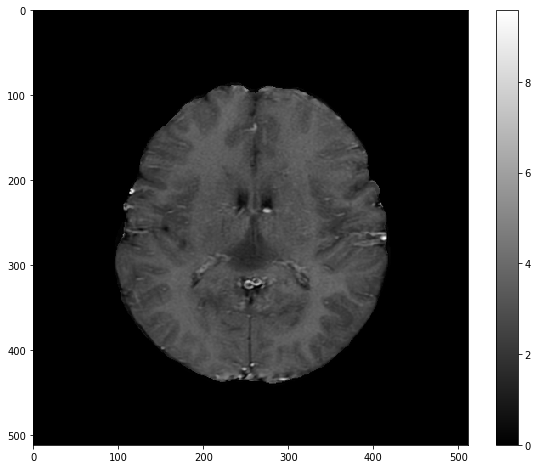

In [16]:
plt.imshow(data[1, 12, 1])
plt.colorbar()

In [5]:
data_rad = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/Rad1.h5', 
                      params={'h5_key': 'all'})

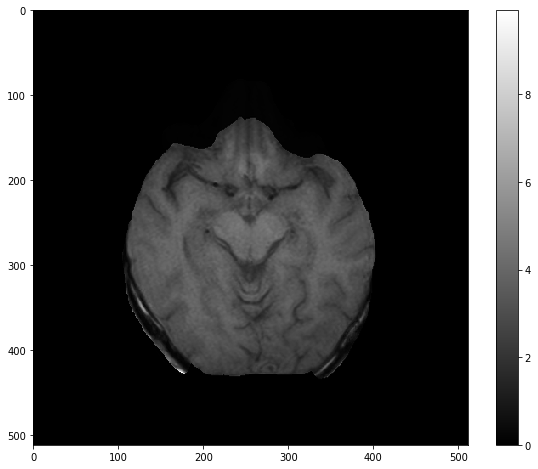

In [17]:
plt.imshow(data_rad[1, 12, 1])
plt.colorbar()

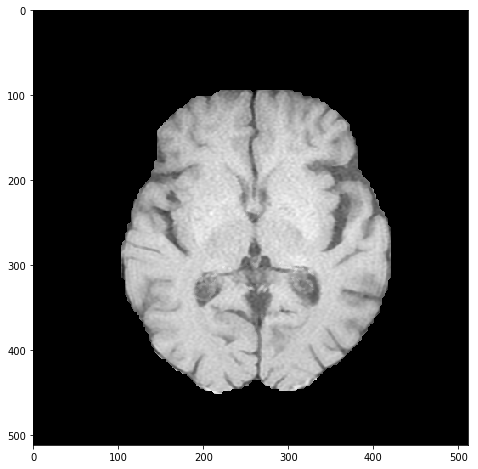

In [38]:
d = np.load('6_final.npy')
plt.imshow(d[15])#, vmin=0, vmax=d.max()*0.3)

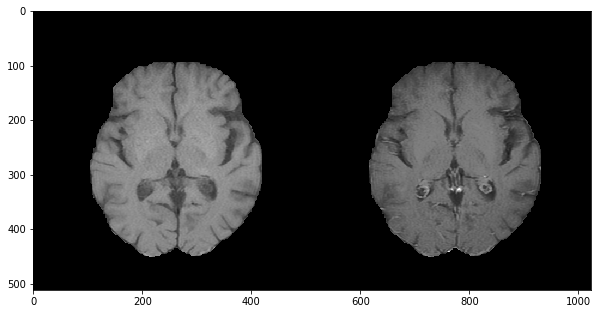

In [29]:
ip = suio.load_file('/home/srivathsa/projects/studies/gad/radnet/preprocess/data/UCHS4.h5', params={'h5_key': 'all'})
plt.imshow(np.hstack([ip[1, 15, 0], ip[1, 15, 2]]))